# Image classification

###이미지에서 고양이와 강아지를 분류하자!


필요한 패키지들을 가져와 시작하자.

`os` 패키지는 파일과 디렉토리 구조를 읽는데 사용된다.

`numpy`는 python list를 numpy array로 변환하고 필요한 matrix 연산을 수행한다.

`matplotlib.pyplot`은 그래프를 작성하고 training 및 validation data에 대한 이미지를 프리뷰하는데 사용한다.

In [ ]:
try: 
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## 데이터 로드

캐글에서 <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs Cats</a> 데이터셋을 내려받아 준비한다.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 0s 0us/step


데이터셋의 구조는 아래와 같습니다.

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

내용을 압축해제한 뒤 training 및 validation set에 적합한 파일 경로로 변수를 할당한다.

In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### 데이터에 대한 이해

얼마나 많은 고양이와 개의 이미지가 있는지 살펴봅시다.

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


편의를 위해 dataset을 preprocessing하고 네트워크를 학습할 때 사용할 변수를 설정한다.

In [ ]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

## 데이터 준비

네트워크에 데이터를 들이붓기 전에 이미지를 적절히 사전처리하여 float Tensor로 변환하자.

1. 디스크에서 이미지 읽기
2. 이러한 이미지의 콘텐츠를 디코딩하고 RGB 컨텐츠에 따라 적절한 그리드 형식으로 변환한다.
3. float Tensor로 변환한다.
4. Neural Network가 작은 입력 값 처리를 선호하기에 텐서를 0과 255 사이의 값에서 0과 1 사이의 값으로 다시 조정한다.

이 모든 작업은 `tf.keras`가 제공하는 `ImageDataGenerator`를 통해 수행할 수 있다. 디스크에서 이미지를 읽고 적절한 텐서 안으로 사전 처리할 수 있습니다.

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

Training 및 Validation용 generator를 정의한 후 `flow_from_directory` 메소드는 디스크에서 이미지를 로드하고, 다시 스케일을 적용하며, 필요한 치수로 이미지 크기를 조정한다.

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [ ]:
train_data_gen.class_indices

{'cats': 0, 'dogs': 1}

### training image의 시각화

training generator에서 image를 추출하여 training image를 시각화하자. 그 중 5개는 `matplotlib`로 표시하자.

In [ ]:
sample_training_images, sample_training_labels = next(train_data_gen)

`next` 기능은 datset에서 batch를 반환한다. `next` 함수의 반환값은 `(x_train, y_train)`, x_train은 training image이며 y_train은 label이다.

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

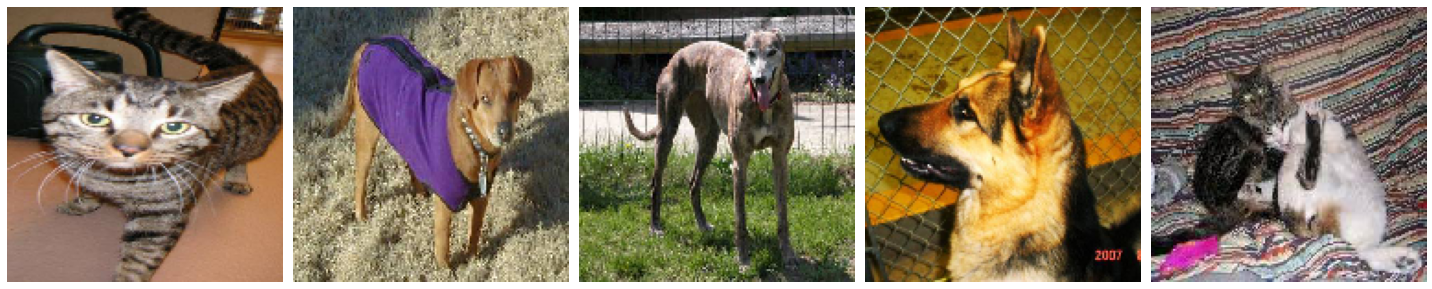

[0. 1. 1. 1. 0.]


In [ ]:
plotImages(sample_training_images[:5])
print(sample_training_labels[:5])

In [ ]:
sample_training_images[0].shape  # 이미지 한 장당 가로세로 150픽셀 RGB컬러 이미지임을 알 수 있다

(150, 150, 3)

## 모델 만들기

모델은 각각 maxpooling layer가 있는 세 개의 convolution block들로 구성된다. 뒤에는 512 FC layer가 있고, `relu` activation function이 배치되어 있다.

# 실습 MISSION
* CNN 뒤에 ReLU Activation Function을 적용한 512 fully connected Layer를 추가해보자.

* 그 뒤 binary classification이 가능하도록 1개의 출력값이 나오도록 다시 FC layer 한 층을 추가한다. 이 때 sigmoid를 활용한다.



In [ ]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    #### ANSWER ####
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
    ################
])

### 모델 컴파일하기

이 학습 자료에서는 *ADAM* optimizer 및 *Binary Cross Entropy* loss function을 선택한다. 각 training epoch에서 교육 및 검증 정확도를 보려면 `metrics` argumnet를 사용하면 된다.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

`tf.keras.utils.plot_model` 메소드를 통해 모델을 시각화할 수 있다.

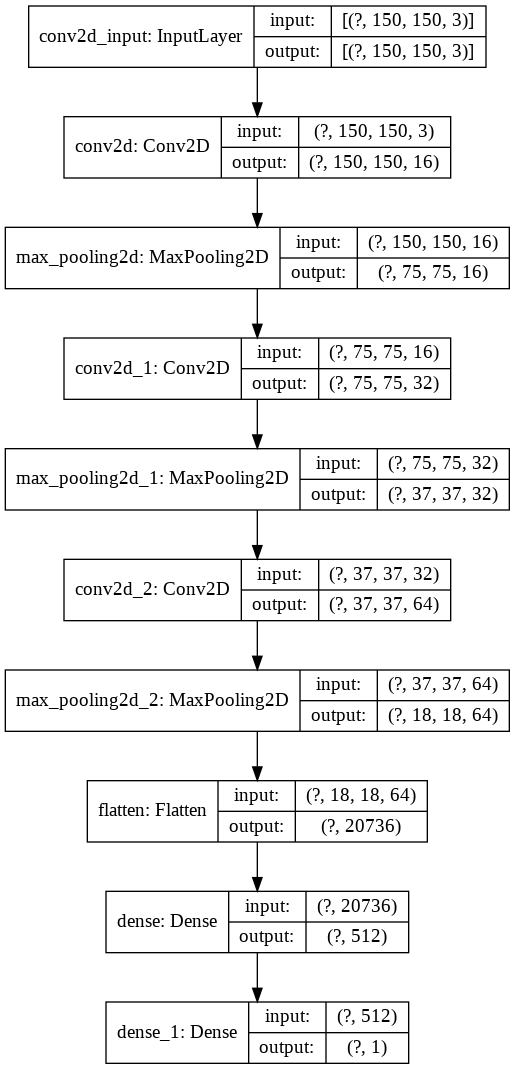

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### 모델 학습시키기

`ImageDataGenerator` 클래스의 `fit_generator` 메소드를 사용하여 네트워크를 교육한다.

In [ ]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
15/15 [==============================] - 8s 505ms/step - loss: 0.9661 - accuracy: 0.5043 - val_loss: 0.6948 - val_accuracy: 0.4978
Epoch 2/15
15/15 [==============================] - 7s 478ms/step - loss: 0.6906 - accuracy: 0.5358 - val_loss: 0.6789 - val_accuracy: 0.6496
Epoch 3/15
15/15 [==============================] - 7s 480ms/step - loss: 0.6526 - accuracy: 0.6319 - val_loss: 0.6870 - val_accuracy: 0.5279
Epoch 4/15
15/15 [==============================] - 7s 476ms/step - loss: 0.6075 - accuracy: 0.6554 - val_loss: 0.6126 - val_accuracy: 0.6685
Epoch 5/15
15/15 [==============================] - 7s 475ms/step - loss: 0.5334 - accuracy: 0.7415 - val_loss: 0.5902 - val_accuracy: 0.7009
Epoch 6/15
15/15 [==============================] - 7s 478ms/step - loss: 0.4864 - accuracy: 0.7714 - val_loss: 0.5813 - val_accuracy: 0.7009
Epoch 7/15
15/15 [==============================] - 7s 482ms/step - loss

### 학습 결과 시각화

이제 학습이 끝났으면 결과를 시각화 해보자.

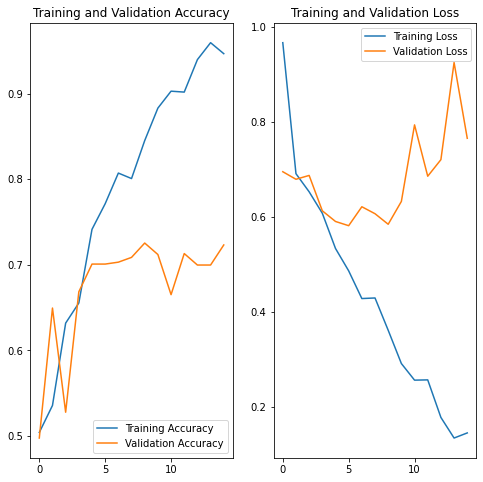

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###<font color='red'>잠깐 Quiz</font>
> 위 그래프를 통해 확인할 수 있는 문제점은?

## Data augmentation

데이터의 증가는 신뢰할 수 있는 이미지를 생성하는 무작위 변환을 사용하여 샘플을 증가시켜 기존 학습 샘플에서 더 많은 훈련데이터를 생성하는 접근 방식을 취한다. 목표는 이 모델이 학습 중에 똑같은 사진을 한 번 더 보지 못하게 하는데 있다. 이는 모델에 데이터의 더 일반화된 특성을 노출시키는데 도움이 된다.


이를 `ImageDataGenerator` 클래스를 사용하여 `tf.keras`에서 구현한다. 다양한 변환을 데이터 세트에 전달하면 교육 프로세스 중에 이를 적용해야 한다.

### Augment 와 데이터 시각화


데이터셋에 random horizontal flip augmentaiton을 적용하여 변환 후 개별 이미지가 어떻게 보이는지 확인하자.

### horizontal flip 적용

`horizontal_flip`을 `ImageDataGenerator` Class에 대한 argument로 전달하고 이 augmnetation을 적용하려면 `True`로 설정한다.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


교육 예제에서 하나의 샘플 이미지를 추출한 후 5회 반복하여 동일한 이미지에 5회 augmentation이 적용되도록 한다.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

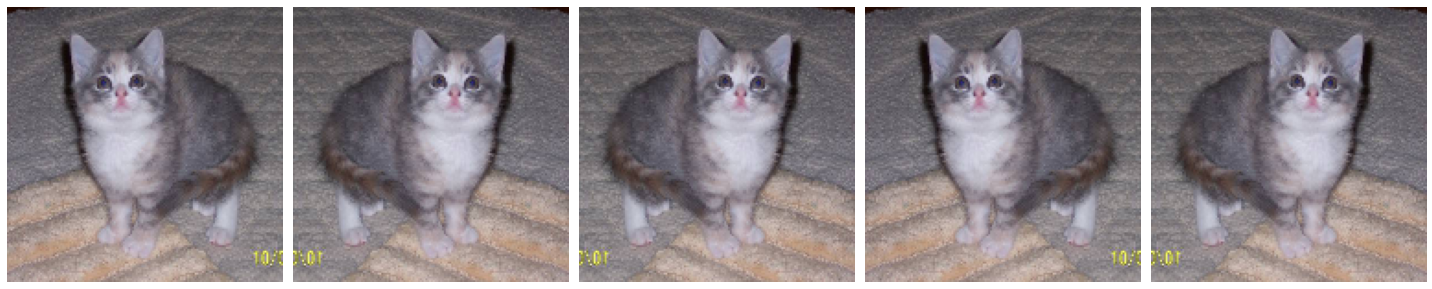

In [ ]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image

rotation augmentation을 적용하여 학습 이미지가 무작위로 45도 회전하도록 해보자.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


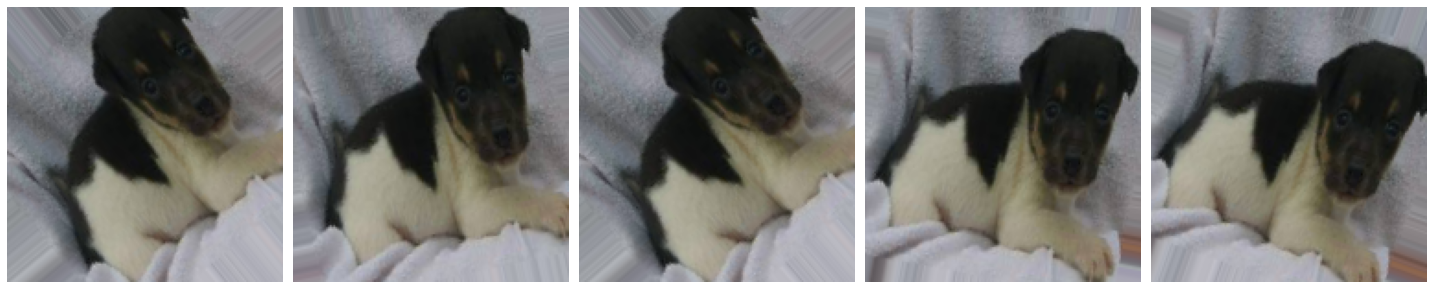

In [ ]:
plotImages(augmented_images)

### zoom augmentation 적용

zoom augmentation을 적용하고 이미지들에 무작위로 최대 50% 줌을 적용해보자.

In [ ]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)  # 50% ~ 150%

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


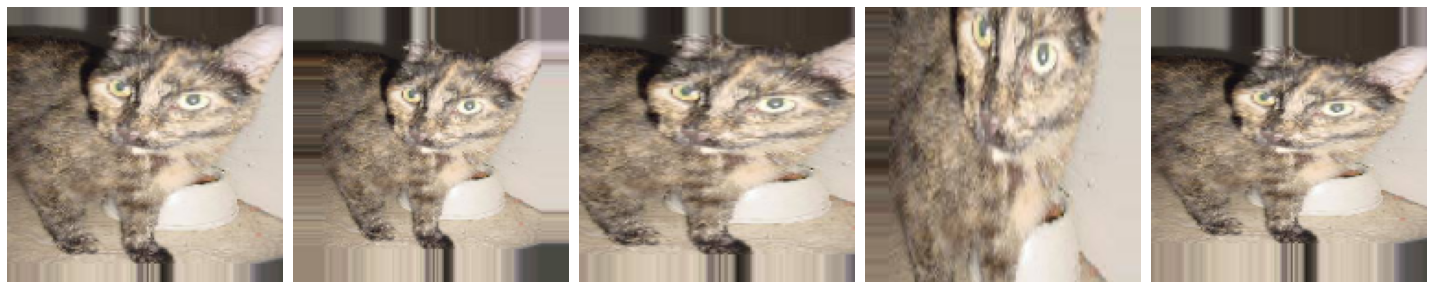

In [ ]:
plotImages(augmented_images)

### 한 번에 적용하기

# 실습 MISSION

> 지금까지의 모든 augmentation을 적용해보자.

* rescale
* 10도 회전
* width shift 중앙 기준 10%범위
* height shift 중앙 기준 15%범위
* horizontal flip
* zoom augmentation 5%

[참고 Documentation](https://keras.io/preprocessing/image/)

In [ ]:
image_gen_train = ImageDataGenerator(
                    #### ANSWER ####
                    rescale=1./255,
                    rotation_range=10,
                    width_shift_range=0.1,
                    height_shift_range=0.15,
                    horizontal_flip=True,
                    zoom_range=0.05
                    ################
                    )

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


데이터셋에 무작위로 이러한 augmentation을 전달할 때 단일 이미지가 어떻게 다섯 번 다르게 보이는지 시각화해보자.

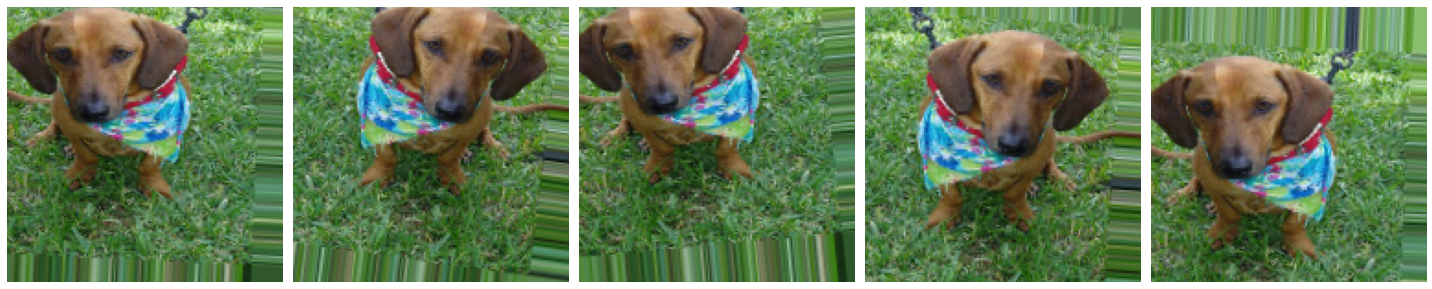

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### validation data generator 만들기

일반적으로 data augmentation은 training example에만 적용하므로, validation data generator는 `ImageDataGenerator`로부터 `rescale`만 적용하여 작성하도록 하자.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


# 실습 MISSION

아래 네트워크의 모든 MaxPooling 뒤에, 0.2만큼 노드를 비활성화시키는 dropout을 추가하자.

Dense 사이에도 0.5만큼 노드를 비활성화시키는 dropout을 추가하자.

In [ ]:
model_new = Sequential([
                        #### ANSWER ####
                        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
                        MaxPooling2D(),
                        Dropout(0.2),
                        Conv2D(32, 3, padding='same', activation='relu'),
                        MaxPooling2D(),
                        Dropout(0.2),
                        Conv2D(64, 3, padding='same', activation='relu'),
                        MaxPooling2D(),
                        Dropout(0.2),
                        Flatten(),
                        Dense(512, activation='relu'),
                        Dropout(0.5),
                        Dense(1, activation='sigmoid')
                        ################
])

### 모델 컴파일하기

네트워크에 dropout들을 인가하고, 모델을 컴파일한 뒤 서머리를 확인하자.

In [ ]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

In [ ]:
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)       

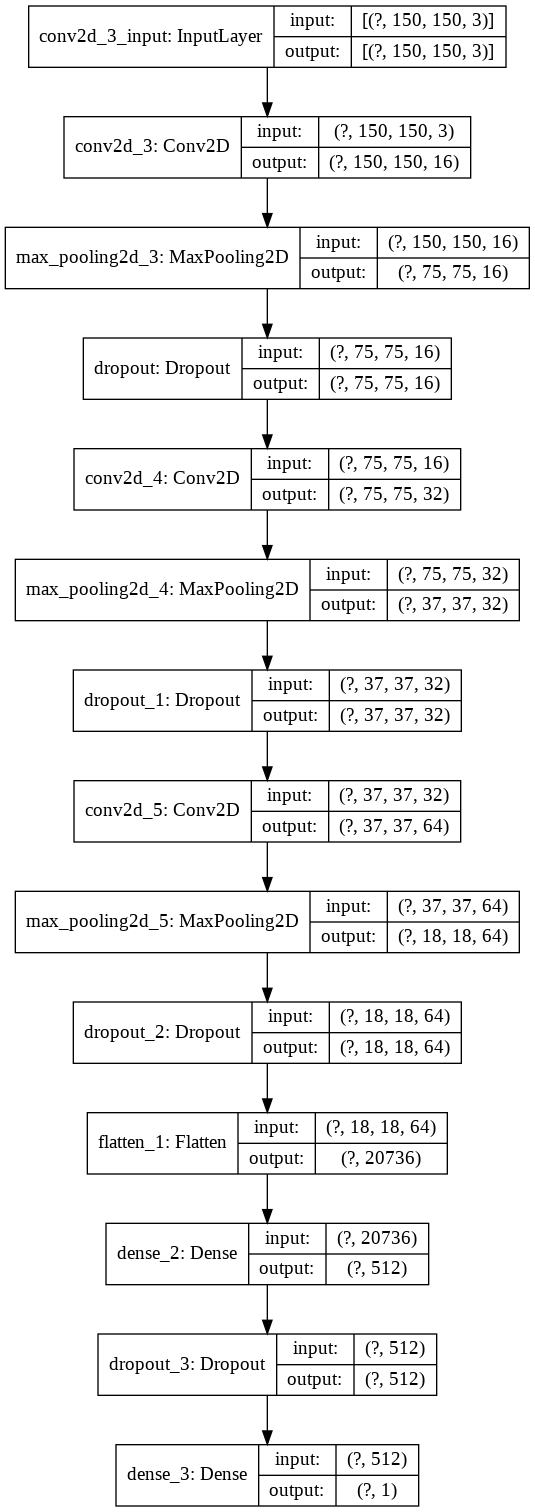

In [ ]:
tf.keras.utils.plot_model(model_new, show_shapes=True)

### 모델 학습시키기


교육 예제에 Data Augmentation을 도입하고 네트워크에 dropout을 추가한 후 네트워크를 학습시키자.

이 때 Augmentation을 적용했으므로 Epoch를 늘려야한다는 것을 잊지 말자!

In [ ]:
epochs_new = 50

In [ ]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs_new,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/50
15/15 [==============================] - 15s 995ms/step - loss: 0.9437 - accuracy: 0.4840 - val_loss: 0.6927 - val_accuracy: 0.5033
Epoch 2/50
15/15 [==============================] - 14s 948ms/step - loss: 0.6922 - accuracy: 0.5043 - val_loss: 0.6913 - val_accuracy: 0.5513
Epoch 3/50
15/15 [==============================] - 14s 946ms/step - loss: 0.6874 - accuracy: 0.5395 - val_loss: 0.6855 - val_accuracy: 0.5179
Epoch 4/50
15/15 [==============================] - 14s 949ms/step - loss: 0.6786 - accuracy: 0.5678 - val_loss: 0.6743 - val_accuracy: 0.5614
Epoch 5/50
15/15 [==============================] - 14s 944ms/step - loss: 0.6649 - accuracy: 0.6036 - val_loss: 0.6639 - val_accuracy: 0.5949
Epoch 6/50
15/15 [==============================] - 14s 941ms/step - loss: 0.6614 - accuracy: 0.6074 - val_loss: 0.6613 - val_accuracy: 0.6205
Epoch 7/50
15/15 [==============================] - 14s 941ms/step - loss: 0.6490 - accuracy: 0.6432 - val_loss: 0.6427 - val_accuracy: 0.6328

### 학습 결과 시각화

학습이 끝난 후 새로운 모델을 시각화 해보자. overfitting이 크게 줄어든 것을 확인할 수 있다. 정확성을 높이기 위해서는 모델을 더 충분히 훈련시켜야 한다.

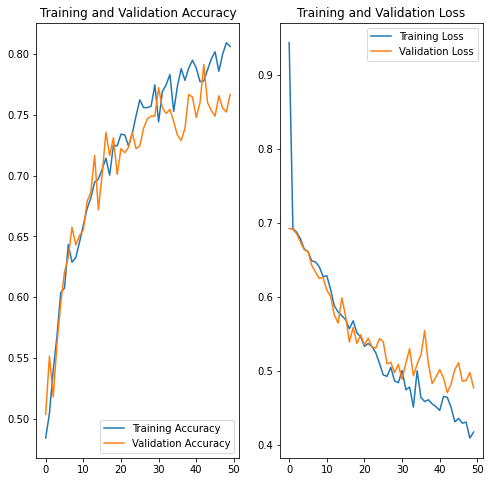

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(epochs_new)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 학습된 모델로 Inference해보기

개와 고양이 이미지를 내려받는다.

In [ ]:
!wget -O dog_sample.jpg https://www.guidingeyes.org/wp-content/uploads/2020/01/1-1.jpg
!wget -O cat_sample.jpg https://www.rd.com/wp-content/uploads/2019/11/cat-10-e1573844975155-768x519.jpg

--2020-09-20 16:35:10--  https://www.guidingeyes.org/wp-content/uploads/2020/01/1-1.jpg
Resolving www.guidingeyes.org (www.guidingeyes.org)... 34.73.250.10
Connecting to www.guidingeyes.org (www.guidingeyes.org)|34.73.250.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49500 (48K) [image/jpeg]
Saving to: ‘dog_sample.jpg’

dog_sample.jpg      100%[===================>]  48.34K  --.-KB/s    in 0.1s    

2020-09-20 16:35:11 (351 KB/s) - ‘dog_sample.jpg’ saved [49500/49500]

--2020-09-20 16:35:11--  https://www.rd.com/wp-content/uploads/2019/11/cat-10-e1573844975155-768x519.jpg
Resolving www.rd.com (www.rd.com)... 104.18.24.214, 104.18.25.214, 2606:4700::6812:19d6, ...
Connecting to www.rd.com (www.rd.com)|104.18.24.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47315 (46K) [image/jpeg]
Saving to: ‘cat_sample.jpg’

cat_sample.jpg      100%[===================>]  46.21K  --.-KB/s    in 0s      

2020-09-20 16:35:11 (109 MB/s) - ‘ca

이미지를 학습시킨 모델에 맞추어 rescale 후 (1, 150, 150, 3)로 변환시킨다.

In [ ]:
# keras 라이브러리를 이용한 방법
def img2input_keras(path, target_size):
  img_show = plt.imread(path)
  plt.imshow(img_show)
  tmp = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
  tmp = tf.keras.preprocessing.image.img_to_array(tmp)
  tmp = tmp/255.
  tmp = np.expand_dims(tmp, axis=0)
  print(tmp.shape)
  return tmp

(1, 150, 150, 3)


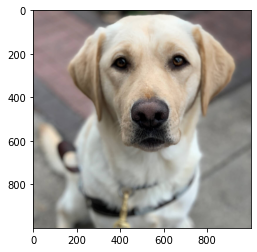

In [ ]:
dog_input = img2input_keras('dog_sample.jpg', (150, 150))

(1, 150, 150, 3)


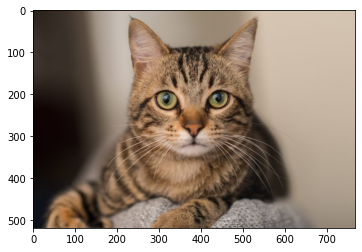

In [ ]:
cat_input = img2input_keras('cat_sample.jpg', (150, 150))

In [ ]:
print('dog image -> ', model.predict(dog_input))

dog image ->  [[0.6361059]]


In [ ]:
print('cat image -> ', model.predict(cat_input))

cat image ->  [[0.02823413]]


In [ ]:
print('with new model, dog image -> ', model_new.predict(dog_input))

with new model, dog image ->  [[0.5567053]]


In [ ]:
print('with new model, cat image -> ', model_new.predict(cat_input))

with new model, cat image ->  [[0.01936009]]
